# KAKURO solver 

## with GA

In [1]:
import collections
import random
import numpy
from deap import algorithms,base,creator,tools
import time
import math
import matplotlib.pyplot as plt
import copy
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Initialize four playing fields with different difficulty levels

In [43]:
easy=[
    ['b',[0,17],[0,16]],
    [[17,0],'w','w'],
    [[16,0],'w','w']
]

medium = [
    ['b',[0,3],[0,9],'b'],
    [[4,0],'w','w',[0,3]],
    [[8,0],'w','w','w'],
    ['b',[3,0],'w','w']
]

expert = [
    ['b',[0,7],[0,23],'b','b'],
    [[10,0],'w','w',[0,24],[0,7]],
    [[16,0],'w','w','w','w'],
    [[22,0],'w','w','w','w'],
    ['b','b',[13,0],'w','w']
]

impossible = [
    ['b',[0,13],[0,23],'b',[0,43],[0,5],'b','b'],
    [[17,0],'w','w',[4,0],'w','w','b','b'],
    [[8,0],'w','w',[12,12],'w','w','b','b'],
    [[27,0],'w','w','w','w','b','b','b'],
    ['b','b',[8,0],'w','w',[0,7],'b','b'],
    ['b','b','b',[7,0],'w','w',[0,24],[0,10]],
    ['b','b','b',[28,16],'w','w','w','w'],
    ['b','b',[10,0],'w','w',[9,0],'w','w'],
    ['b','b',[11,0],'w','w',[12,0],'w','w'],
]

### Function for beautiful output

In [3]:
def printMatrix ( matrix): 
    for i in range ( len(matrix) ): 
        for j in range(len(matrix[i]) ): 
            if matrix[i][j]=='b':
                print('|XXXXX|', end = "")
            if matrix[i][j]=='w':
                print('|_____|', end = "")
            if isinstance(matrix[i][j], list):
                print ( "|{:2d}/{:2d}|".format(matrix[i][j][0],matrix[i][j][1]), end = "" )
            if isinstance(matrix[i][j], int):
                print( "|{:4d} |".format(matrix[i][j]), end = "" )
        print ()

### Function for counting empty cells

In [4]:
def count_Spaces(matrix):
    counter=0
    for row in range(len(matrix)):
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                counter+=1
    return counter 

### Function initializing beginning of the game and difficulty level

In [48]:
def start():
    print('_________Choose level:_________ \n1-Easy \n2-Medium \n3-Hard \n4-Expert')
    a=int(input())
    if a==1:
        matrix=easy
        print('_________You choose easy_________\n') 
        printMatrix ( matrix)
    elif a==2:
        matrix=medium
        print('_________You choose medium_________\n')
        printMatrix ( matrix)
    elif a==3:
        matrix=expert
        print('_________You choose hard_________\n')
        printMatrix ( matrix)  
    elif a==4:
        matrix=impossible
        print('_________You choose expert_________\n')
        printMatrix ( matrix)       
    else:
        print('WRONG') 
    
    countspaces=count_Spaces(matrix)
    print('\n_________Number of spaces {}_________'.format(countspaces))
    print()
    return (matrix,countspaces)    

### To assess Fitness, we will consider the number of duplicate elements vertically and horizontally, as well as the difference in the amounts in the groups (the actual amount minus the amount necessary)

In [6]:
# ____________CHECK_RIGHT_NEIGHBOUR____________________

def check_right(row,column,matrix):
    try:
        if isinstance(matrix[row][column+1], int):
            return True
    except:
        return False
    
# __________________CHECK_DOWN_NEIGHBOUR______________________

def check_down(row,column,matrix):
    try:
        if isinstance(matrix[row+1][column], int):
            return True
    except:
        return False    
    
# _____________COUNT_OF_DUBLICATE_NUMBERS_IN_HORIZONTAL_____________

def check_dubble_hor(matrix):
    counter=0
    for row in range(len(matrix)):
        a=[]
        for column in range(len(matrix[0])):
            if isinstance(matrix[row][column], int):
                a.append(matrix[row][column])
                if check_right(row,column,matrix):
                    continue
                else:
                    z=sum([value-1 for key,value in collections.Counter(a).items() if value>1] )
                    counter+=z
                    a=[]
    return counter                

# ____________COUNT_OF_DUBLICATE_NUMBERS_IN_VERTICAL_________

def check_dubble_vert(matrix):
    counter=0
    for column in range(len(matrix[0])):
        a=[]
        for row in range(len(matrix)):
            if isinstance(matrix[row][column], int):
                a.append(matrix[row][column])
                if check_down(row,column,matrix):
                    continue
                else:
                    z=sum([value-1 for key,value in collections.Counter(a).items() if value>1] )
                    counter+=z
                    a=[]
    return counter   

# _______________DIFFERENCE_IN_SUM_IN_HORIZONTAL_______

def check_sum_hor(matrix):
    counter=0
    for row in range(len(matrix)):
        a=[]
        summ=0
        for column in range(len(matrix[0])):
            if isinstance(matrix[row][column], list):
                summ=matrix[row][column][0]
                continue
            if isinstance(matrix[row][column], int):   
                a.append(matrix[row][column])
                if check_right(row,column,matrix):
                    continue
                else:
                    counter+=abs(sum(a)-summ)
                    a=[]
    return counter    

# ______________DIFFERENCE_IN_SUM_IN_VERTICAL_____________

def check_sum_vert(matrix):
    counter=0
    for column in range(len(matrix[0])):
        a=[]
        summ=0
        for row in range(len(matrix)):
            if isinstance(matrix[row][column], list):
                summ=matrix[row][column][1]
                continue
            if isinstance(matrix[row][column], int):   
                a.append(matrix[row][column])
                if check_down(row,column,matrix):
                    continue
                else:
                    counter+=abs(sum(a)-summ)
                    a=[]
    return counter 



### Function to fill the playing field with data from the array

In [7]:
def filling_desc(array):
    if len(array)!=count_spaces:
        return False
    desc=copy.deepcopy(matrix)
    i=0
    for row in range(len(desc)):
        for column in range(len(desc[0])):
            if desc[row][column]=='w':
                desc[row][column]=array[i]
                i+=1
    return desc 

### Fitness

In [8]:
def evaluation(individual):
    desc=filling_desc(individual)
    dubble_hor=check_dubble_hor(desc)
    dubble_vert=check_dubble_vert(desc)
    sum_vert=check_sum_vert(desc)
    sum_hor=check_sum_hor(desc)
    fitness=dubble_hor+dubble_vert+sum_vert+sum_hor
    return fitness,

### Function mutation

In [83]:
def mut_k_point(individual,k):
    n=0
    while n!=k:
        index=random.sample(range(len(individual)),1)[0]
        variation=[x for x in range(1,len(individual)) if x!=individual[index]]
        (individual[index])=random.sample(variation,1)[0]
        n+=1
    return (individual,) 

### Create a function GA

In [10]:
def ga(pop=500,tournsize_n=7,k_mut=1,sel=tools.cxOnePoint,cx_pb=0.7,mt_pb=0.001):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("array", random.randint, 1, 9)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.array, n=count_spaces)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluation)
    toolbox.register("mate", sel)
    toolbox.register("mutate", mut_k_point,k=k_mut)
    toolbox.register("select", tools.selTournament, tournsize=tournsize_n)

    pop = toolbox.population(n=pop)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Average", numpy.mean)
    stats.register("Median", numpy.median)
    stats.register("Min", numpy.min)
    stats.register("Max", numpy.max)

    before = time.time()
    a,v=algorithms.eaSimple(pop, toolbox, cxpb=cx_pb, mutpb=mt_pb, ngen=100, stats=stats,
                                halloffame=hof, verbose=False)
    after=time.time() 
    tm=after-before
    avg=v.select("Average")
    md=v.select("Median")
    mn=v.select("Min")
    mx=v.select("Max")
    gen=v.select("gen")
    return(tm,avg,md,mn,mx,gen,hof)

### Drawing function

In [38]:
def graf(gen,avg,mn,mx,md,mt_pb,cx_pb,sel,k_mut):
    fig, ax = plt.subplots(figsize = (14, 8))
    line_avg = ax.plot(gen, avg, label='Average individ')
    line_max = ax.plot(gen, mn, label='Best individ')
    line_min = ax.plot(gen, mx, label='Whorst individ')
    line_md = ax.plot(gen, md, label='Median individ')
    ax.legend()
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    ax.set_title('''Array \n Mutation probability {}% \n Crossover probability {}% \n  
{} \n {} point mutation \n Tournament selection'''.format(mt_pb,cx_pb,sel,k_mut))
    plt.show()

## Game launch and analysis of results

### Attempt 1 = Level Easy

_________Choose level:_________ 
1-Easy 
2-Medium 
3-Hard 
4-Expert
1
_________You choose easy_________

|XXXXX|| 0/17|| 0/16|
|17/ 0||_____||_____|
|16/ 0||_____||_____|

_________Number of spaces 4_________



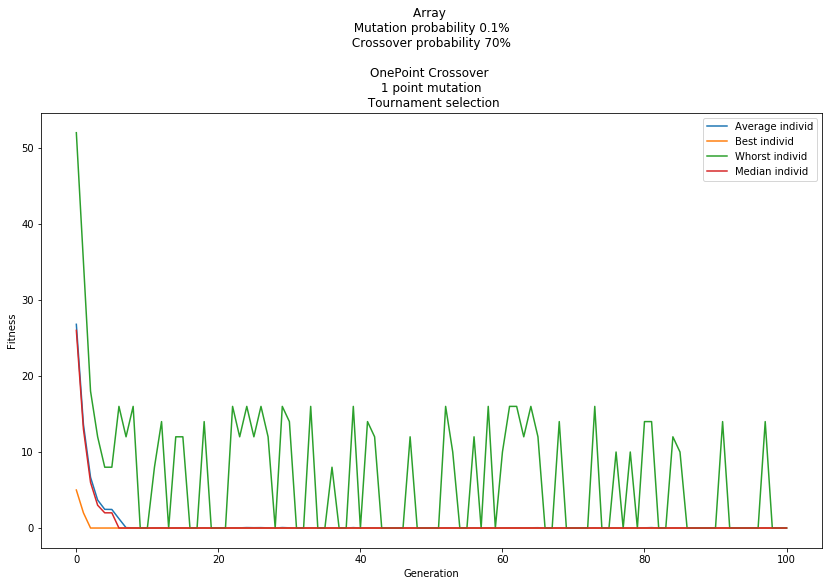

The best solution:
|XXXXX|| 0/17|| 0/16|
|17/ 0||   8 ||   9 |
|16/ 0||   9 ||   7 |
Fitness: 0
Array: [8, 9, 9, 7]
Algorithms time 5.9460608959198


In [159]:
matrix,count_spaces=start()
tm,avg,md,mn,mx,gen,hof=ga()
graf(gen,avg,mn,mx,md,0.1,70,'OnePoint Crossover',1)
print('The best solution:')
best_desc=filling_desc(hof[0])
printMatrix(best_desc)
fit=evaluation(hof[0])[0]
print('Fitness: {}'.format(fit))
print('Array:',hof[0])
print('Algorithms time',tm) 

### Attempt 2 = Level Medium

_________Choose level:_________ 
1-Easy 
2-Medium 
3-Hard 
4-Expert
2
_________You choose medium_________

|XXXXX|| 0/ 3|| 0/ 9||XXXXX|
| 4/ 0||_____||_____|| 0/ 3|
| 8/ 0||_____||_____||_____|
|XXXXX|| 3/ 0||_____||_____|

_________Number of spaces 7_________



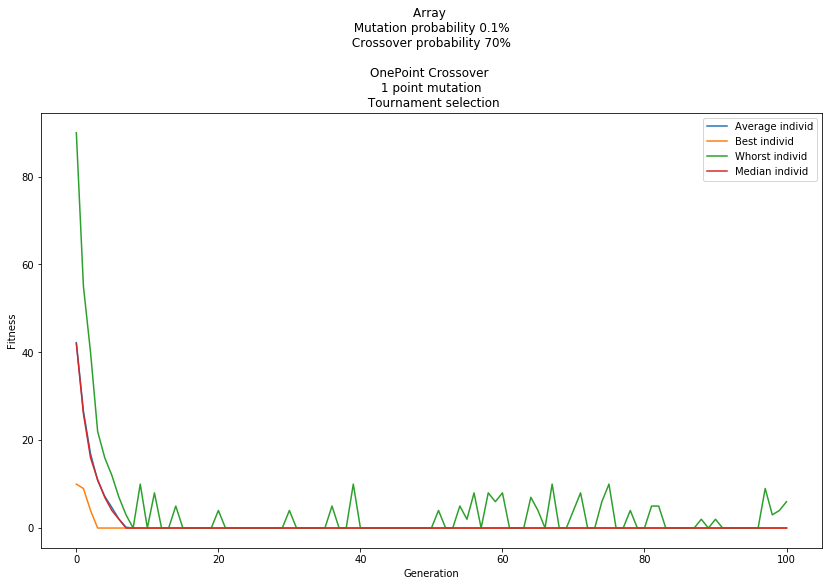

The best solution:
|XXXXX|| 0/ 3|| 0/ 9||XXXXX|
| 4/ 0||   1 ||   3 || 0/ 3|
| 8/ 0||   2 ||   5 ||   1 |
|XXXXX|| 3/ 0||   1 ||   2 |
Fitness: 0
Array: [1, 3, 2, 5, 1, 1, 2]
Algorithms time 7.02602219581604


In [162]:
matrix,count_spaces=start()
tm,avg,md,mn,mx,gen,hof=ga()
graf(gen,avg,mn,mx,md,0.1,70,'OnePoint Crossover',1)
print('The best solution:')
best_desc=filling_desc(hof[0])
printMatrix(best_desc)
fit=evaluation(hof[0])[0]
print('Fitness: {}'.format(fit))
print('Array:',hof[0])
print('Algorithms time',tm) 

### Attempt 3 = Level Hard

_________Choose level:_________ 
1-Easy 
2-Medium 
3-Hard 
4-Expert
3
_________You choose hard_________

|XXXXX|| 0/ 7|| 0/23||XXXXX||XXXXX|
|10/ 0||_____||_____|| 0/24|| 0/ 7|
|16/ 0||_____||_____||_____||_____|
|22/ 0||_____||_____||_____||_____|
|XXXXX||XXXXX||13/ 0||_____||_____|

_________Number of spaces 12_________



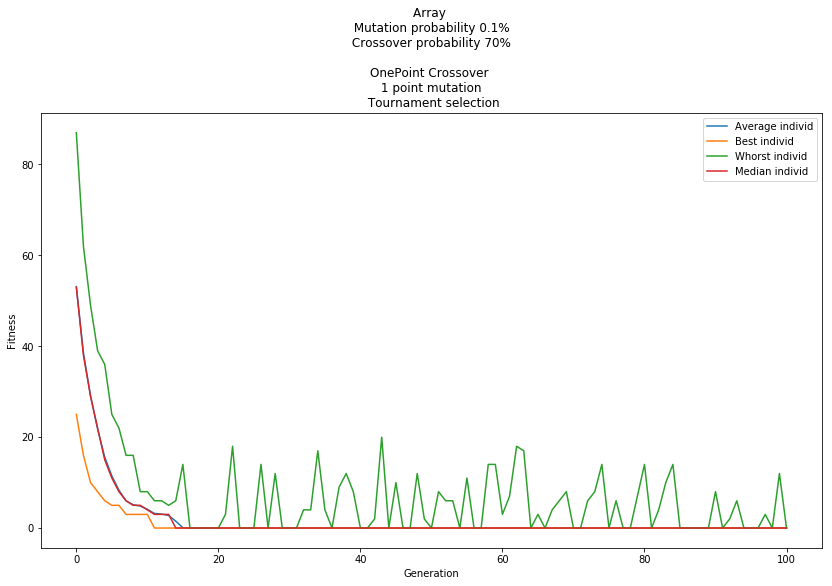

The best solution:
|XXXXX|| 0/ 7|| 0/23||XXXXX||XXXXX|
|10/ 0||   2 ||   8 || 0/24|| 0/ 7|
|16/ 0||   1 ||   6 ||   7 ||   2 |
|22/ 0||   4 ||   9 ||   8 ||   1 |
|XXXXX||XXXXX||13/ 0||   9 ||   4 |
Fitness: 0
Array: [2, 8, 1, 6, 7, 2, 4, 9, 8, 1, 9, 4]
Algorithms time 9.995413303375244


In [181]:
matrix,count_spaces=start()
tm,avg,md,mn,mx,gen,hof=ga()
graf(gen,avg,mn,mx,md,0.1,70,'OnePoint Crossover',1)
print('The best solution:')
best_desc=filling_desc(hof[0])
printMatrix(best_desc)
fit=evaluation(hof[0])[0]
print('Fitness: {}'.format(fit))
print('Array:',hof[0])
print('Algorithms time',tm) 
break

### Attempt 4 = Level Hard

_________Choose level:_________ 
1-Easy 
2-Medium 
3-Hard 
4-Expert
4
_________You choose expert_________

|XXXXX|| 0/13|| 0/23||XXXXX|| 0/43|| 0/ 5||XXXXX||XXXXX|
|17/ 0||_____||_____|| 4/ 0||_____||_____||XXXXX||XXXXX|
| 8/ 0||_____||_____||12/12||_____||_____||XXXXX||XXXXX|
|27/ 0||_____||_____||_____||_____||XXXXX||XXXXX||XXXXX|
|XXXXX||XXXXX|| 8/ 0||_____||_____|| 0/ 7||XXXXX||XXXXX|
|XXXXX||XXXXX||XXXXX|| 7/ 0||_____||_____|| 0/24|| 0/10|
|XXXXX||XXXXX||XXXXX||28/16||_____||_____||_____||_____|
|XXXXX||XXXXX||10/ 0||_____||_____|| 9/ 0||_____||_____|
|XXXXX||XXXXX||11/ 0||_____||_____||12/ 0||_____||_____|

_________Number of spaces 28_________



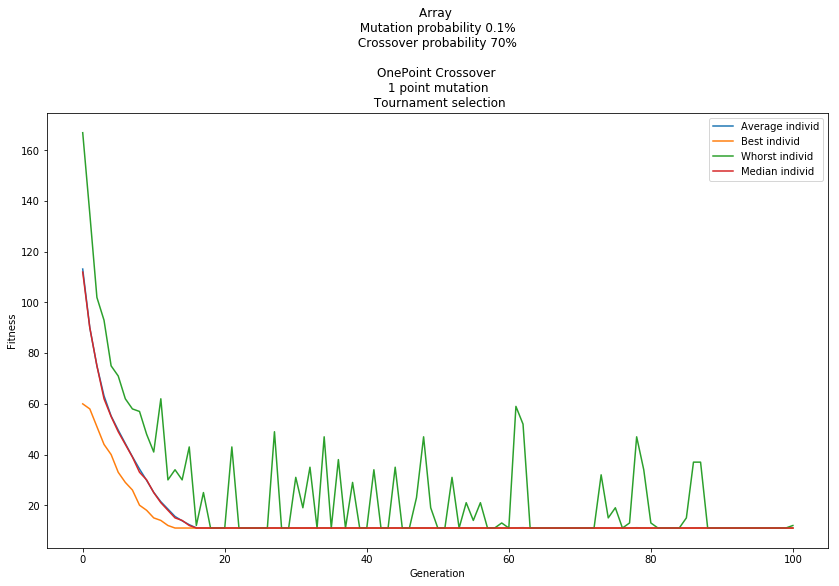

The best solution:
|XXXXX|| 0/13|| 0/23||XXXXX|| 0/43|| 0/ 5||XXXXX||XXXXX|
|17/ 0||   8 ||   9 || 4/ 0||   3 ||   1 ||XXXXX||XXXXX|
| 8/ 0||   1 ||   7 ||12/12||   8 ||   4 ||XXXXX||XXXXX|
|27/ 0||   4 ||   7 ||   5 ||   9 ||XXXXX||XXXXX||XXXXX|
|XXXXX||XXXXX|| 8/ 0||   7 ||   1 || 0/ 7||XXXXX||XXXXX|
|XXXXX||XXXXX||XXXXX|| 7/ 0||   7 ||   2 || 0/24|| 0/10|
|XXXXX||XXXXX||XXXXX||28/16||   9 ||   5 ||   9 ||   5 |
|XXXXX||XXXXX||10/ 0||   9 ||   1 || 9/ 0||   7 ||   1 |
|XXXXX||XXXXX||11/ 0||   7 ||   5 ||12/ 0||   8 ||   4 |
Fitness: 11
Array: [8, 9, 3, 1, 1, 7, 8, 4, 4, 7, 5, 9, 7, 1, 7, 2, 9, 5, 9, 5, 9, 1, 7, 1, 7, 5, 8, 4]
Algorithms time 15.994901895523071


In [154]:
matrix,count_spaces=start()
tm,avg,md,mn,mx,gen,hof=ga()
graf(gen,avg,mn,mx,md,0.1,70,'OnePoint Crossover',1)
print('The best solution:')
best_desc=filling_desc(hof[0])
printMatrix(best_desc)
fit=evaluation(hof[0])[0]
print('Fitness: {}'.format(fit))
print('Array:',hof[0])
print('Algorithms time',tm) 

### Selection of parameters

In [15]:
l_tournsize=[3,5,7]
l_mut=[1,2,3]
l_select=[tools.cxOnePoint,tools.cxTwoPoint]
l_cx_pb=[0.3,0.7,0.9]
l_mt_pb=[0.001,0.01,0.1,0.5]
l_pop=[100,800,2000,5000]

parametrs=list(itertools.product(l_tournsize, l_mut,l_select,l_cx_pb,l_mt_pb,l_pop))

param_dict=[]
for tournsize_n,k_mut,sel,cx_pb,mt_pb,pop in parametrs:
    n=0
    fit=0
    while n!=3:
        tm,avg,md,mn,mx,gen,hof=ga(pop=pop,tournsize_n=tournsize_n,k_mut=k_mut,sel=sel,cx_pb=cx_pb,mt_pb=mt_pb)
        if evaluation(hof[0])[0]==0:
            fit+=1
        if fit==2:
            param_dict.append((tournsize_n,k_mut,sel,cx_pb,mt_pb,pop,hof[0]))
        n+=1  

### Results

In [32]:
n=1
for q,w,e,r,t,y,u in param_dict:
    print('______Result {}_______'.format(n))
    print('Tournsize_n={}\nMutation Points={}\nCrossover={}\nCx pb={}\nMt pb={}\npop={}\nBest={}'.format(q,w,e,r,t,y,u))
    print('_____________________________')
    print()
    n+=1


______Result 1_______
Tournsize_n=3
Mutation Points=1
Crossover=<function cxTwoPoint at 0x00000195E2B11510>
Cx pb=0.9
Mt pb=0.001
pop=5000
Best=[8, 9, 3, 1, 2, 6, 8, 4, 3, 8, 9, 7, 3, 5, 6, 1, 9, 6, 8, 5, 9, 1, 7, 2, 7, 4, 9, 3]
_____________________________

______Result 2_______
Tournsize_n=3
Mutation Points=1
Crossover=<function cxTwoPoint at 0x00000195E2B11510>
Cx pb=0.9
Mt pb=0.01
pop=5000
Best=[8, 9, 3, 1, 2, 6, 8, 4, 3, 8, 9, 7, 3, 5, 6, 1, 9, 6, 8, 5, 9, 1, 7, 2, 7, 4, 9, 3]
_____________________________

______Result 3_______
Tournsize_n=3
Mutation Points=3
Crossover=<function cxOnePoint at 0x00000195E2B11400>
Cx pb=0.9
Mt pb=0.001
pop=5000
Best=[8, 9, 3, 1, 2, 6, 8, 4, 3, 8, 9, 7, 3, 5, 6, 1, 9, 6, 8, 5, 9, 1, 7, 2, 7, 4, 9, 3]
_____________________________

______Result 4_______
Tournsize_n=3
Mutation Points=3
Crossover=<function cxTwoPoint at 0x00000195E2B11510>
Cx pb=0.7
Mt pb=0.01
pop=5000
Best=[8, 9, 3, 1, 2, 6, 8, 4, 3, 8, 9, 7, 3, 5, 6, 1, 9, 6, 8, 5, 9, 1, 7, 2, 7, 4,

## Apply the best parametrs

### Attempt 4 = Level Hard with parametr selection

_________Choose level:_________ 
1-Easy 
2-Medium 
3-Hard 
4-Expert
3
_________You choose hard_________

|XXXXX|| 0/ 7|| 0/23||XXXXX||XXXXX|
|10/ 0||_____||_____|| 0/24|| 0/ 7|
|16/ 0||_____||_____||_____||_____|
|22/ 0||_____||_____||_____||_____|
|XXXXX||XXXXX||13/ 0||_____||_____|

_________Number of spaces 12_________



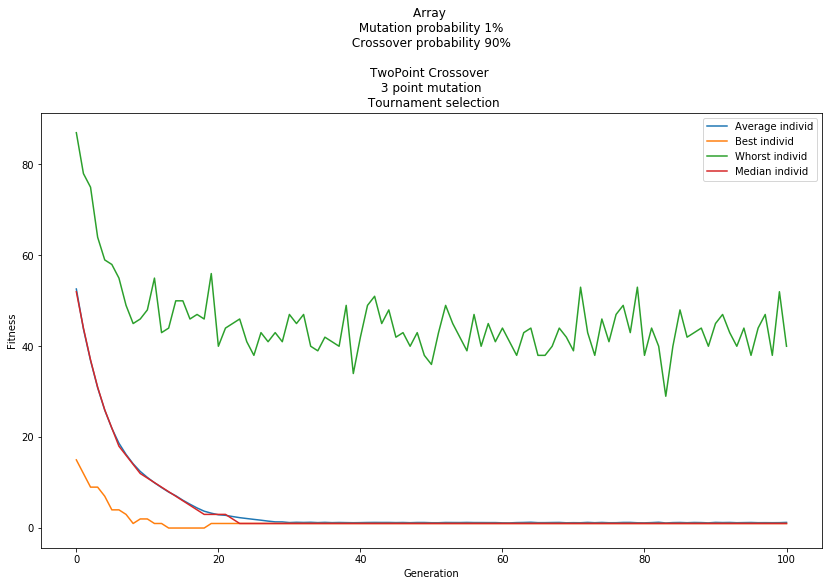

The best solution:
|XXXXX|| 0/ 7|| 0/23||XXXXX||XXXXX|
|10/ 0||   2 ||   8 || 0/24|| 0/ 7|
|16/ 0||   1 ||   6 ||   7 ||   2 |
|22/ 0||   4 ||   9 ||   8 ||   1 |
|XXXXX||XXXXX||13/ 0||   9 ||   4 |
Fitness: 0
Array: [2, 8, 1, 6, 7, 2, 4, 9, 8, 1, 9, 4]
Algorithms time 109.9023756980896


In [155]:
matrix,count_spaces=start()
tm,avg,md,mn,mx,gen,hof=ga(pop=5000,tournsize_n=3,k_mut=3,sel=tools.cxTwoPoint,cx_pb=0.9,mt_pb=0.01)
graf(gen,avg,mn,mx,md,1,90,'TwoPoint Crossover',3)
print('The best solution:')
best_desc=filling_desc(hof[0])
printMatrix(best_desc)
fit=evaluation(hof[0])[0]
print('Fitness: {}'.format(fit))
print('Array:',hof[0])
print('Algorithms time',tm) 

### Attempt 5 = Level Expert with parametr selection

_________Choose level:_________ 
1-Easy 
2-Medium 
3-Hard 
4-Expert
4
_________You choose expert_________

|XXXXX|| 0/13|| 0/23||XXXXX|| 0/43|| 0/ 5||XXXXX||XXXXX|
|17/ 0||_____||_____|| 4/ 0||_____||_____||XXXXX||XXXXX|
| 8/ 0||_____||_____||12/12||_____||_____||XXXXX||XXXXX|
|27/ 0||_____||_____||_____||_____||XXXXX||XXXXX||XXXXX|
|XXXXX||XXXXX|| 8/ 0||_____||_____|| 0/ 7||XXXXX||XXXXX|
|XXXXX||XXXXX||XXXXX|| 7/ 0||_____||_____|| 0/24|| 0/10|
|XXXXX||XXXXX||XXXXX||28/16||_____||_____||_____||_____|
|XXXXX||XXXXX||10/ 0||_____||_____|| 9/ 0||_____||_____|
|XXXXX||XXXXX||11/ 0||_____||_____||12/ 0||_____||_____|

_________Number of spaces 28_________



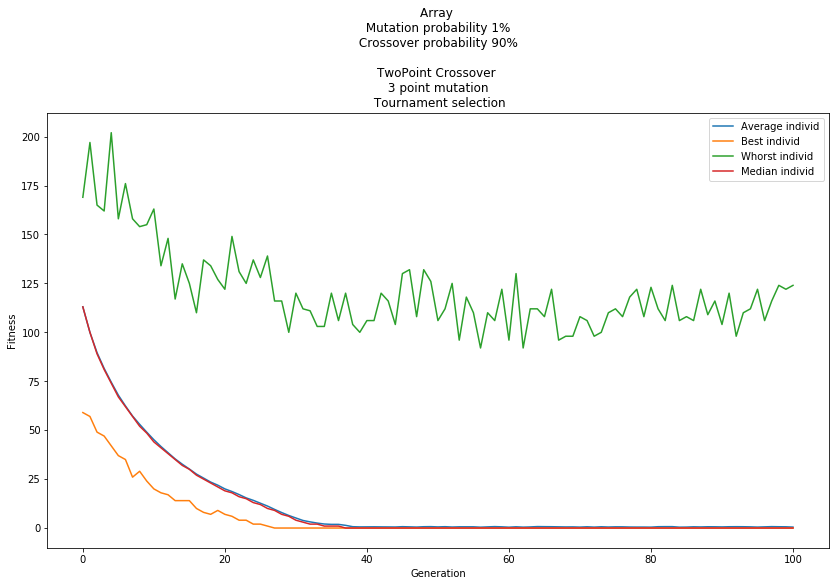

The best solution:
|XXXXX|| 0/13|| 0/23||XXXXX|| 0/43|| 0/ 5||XXXXX||XXXXX|
|17/ 0||   8 ||   9 || 4/ 0||   3 ||   1 ||XXXXX||XXXXX|
| 8/ 0||   2 ||   6 ||12/12||   8 ||   4 ||XXXXX||XXXXX|
|27/ 0||   3 ||   8 ||   9 ||   7 ||XXXXX||XXXXX||XXXXX|
|XXXXX||XXXXX|| 8/ 0||   3 ||   5 || 0/ 7||XXXXX||XXXXX|
|XXXXX||XXXXX||XXXXX|| 7/ 0||   6 ||   1 || 0/24|| 0/10|
|XXXXX||XXXXX||XXXXX||28/16||   9 ||   6 ||   8 ||   5 |
|XXXXX||XXXXX||10/ 0||   9 ||   1 || 9/ 0||   7 ||   2 |
|XXXXX||XXXXX||11/ 0||   7 ||   4 ||12/ 0||   9 ||   3 |
Fitness: 0
Array: [8, 9, 3, 1, 2, 6, 8, 4, 3, 8, 9, 7, 3, 5, 6, 1, 9, 6, 8, 5, 9, 1, 7, 2, 7, 4, 9, 3]
Algorithms time 242.42257595062256


In [156]:
matrix,count_spaces=start()
tm,avg,md,mn,mx,gen,hof=ga(pop=5000,tournsize_n=3,k_mut=3,sel=tools.cxTwoPoint,cx_pb=0.9,mt_pb=0.01)
graf(gen,avg,mn,mx,md,1,90,'TwoPoint Crossover',3)
print('The best solution:')
best_desc=filling_desc(hof[0])
printMatrix(best_desc)
fit=evaluation(hof[0])[0]
print('Fitness: {}'.format(fit))
print('Array:',hof[0])
print('Algorithms time',tm) 

### Time compare

In [74]:
matrix,count_spaces=start()
tm,avg,md,mn,mx,gen,hof=ga(pop=5000,tournsize_n=3,k_mut=3,sel=tools.cxTwoPoint,cx_pb=0.9,mt_pb=0.01)
tm1=round(tm)
tm,avg,md,mn,mx,gen,hof=ga()
tm2=round(tm)
tm_d=round(tm1-tm2)
tm_x=round(tm1/tm2)
print('Time GA light version={} sec.\nTime GA pro version={} sec.\nDifference between={} sec.\nGA light version faster than GA pro version in {} sec.'.format(tm2,tm1,tm_d,tm_x))


_________Choose level:_________ 
1-Easy 
2-Medium 
3-Hard 
4-Expert
1
_________You choose easy_________

|XXXXX|| 0/17|| 0/16|
|17/ 0||_____||_____|
|16/ 0||_____||_____|

_________Number of spaces 4_________

Time GA light version=5 sec.
Time GA pro version=59 sec.
Difference between=54 sec.
GA light version faster than GA pro version in 12 sec.
